# Setup

In [2]:
!pip install datasets ultralytics

In [3]:
from pathlib import Path

In [4]:
def create_dirs():
    current_dir = Path.cwd()

    subdirs = [current_dir / name for name in ("saved_models",)]

    for subdir in subdirs:
        if not subdir.is_dir():
            print(f"Directory '{subdir}' not found. Creating it...")
            subdir.mkdir(parents=True)
            print(f"Created!")

def download_model():
    import requests
    import zipfile
    import os
    from time import sleep

    url = "https://www.dropbox.com/scl/fi/9onrcs3kq1am7nxa3p7gt/saved_model.zip?rlkey=93xfh2smwdsnhjh14jy6dol5q&st=nd4uad3t&dl=0"
    # download model from Dropbox
    try:
        os.system(f"wget -O saved_model.zip {url}")
    except Exception as e:
        print(f"Exception occurred: {e}.")
        if (Path.is_file("saved_model.zip")):
            print("Deleting partially downloaded file...")
            os.remove("saved_model.zip")

    sleep(10)
    with zipfile.ZipFile("saved_model.zip", "r") as zip_ref:
        zip_ref.extractall(model_base_dir)

    os.remove("saved_model.zip")

def setup():
    create_dirs()

    if not model_base_dir.exists() or not any(model_base_dir.iterdir()):
        print("Model not found. Downloading it...")
        download_model()
        print("Downloaded!")

def remove_setup():
    import shutil
    if model_base_dir.exists():
        shutil.rmtree(model_base_dir)
        print(f"Removed directory: {model_base_dir}")
    else:
        print(f"Directory {model_base_dir} does not exist. Nothing to remove.")

model_base_dir = Path.cwd() / "saved_models" / "640"
load_model_dir = model_base_dir / "yolo11n_saved_model"

# remove setup
remove_setup()

setup()

Removed directory: /content/saved_models/640
Model not found. Downloading it...
Downloaded!


# Execution

In [5]:

from datasets import load_dataset

raw_dataset = load_dataset("ilsilfverskiold/traffic-camera-norway-images")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [37]:
import numpy as np
from PIL import Image
import tensorflow as tf
import numpy as np

# Cargar modelo
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO(load_model_dir, task= 'detect')
model.conf = 0.6
# model.iou = 0.1

Randomly sampling 10 images from validation dataset...
Got 10 images!


Running inference on 10 images...:   0%|          | 0/10 [00:00<?, ?it/s]

No objects detected in image 0.


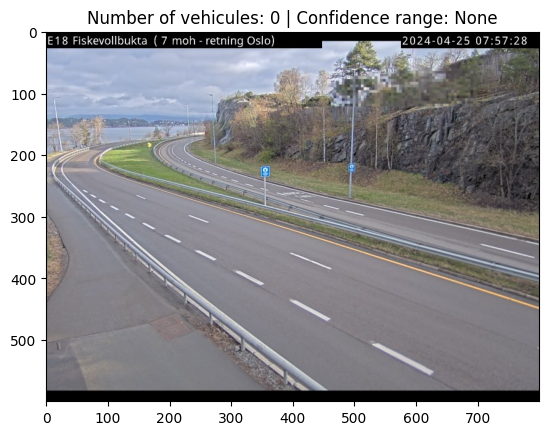

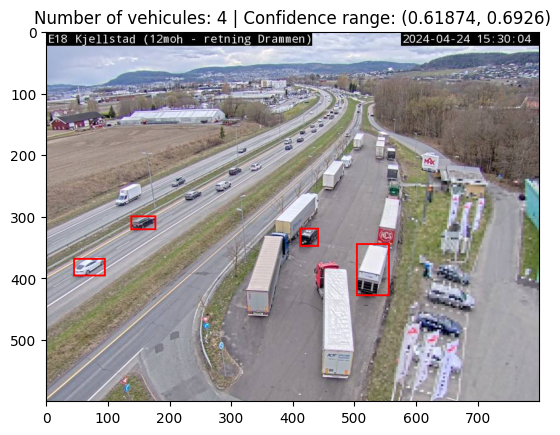

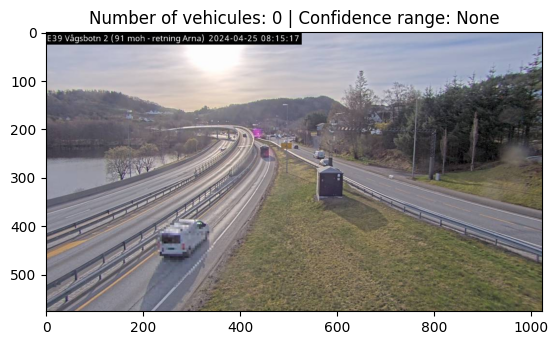

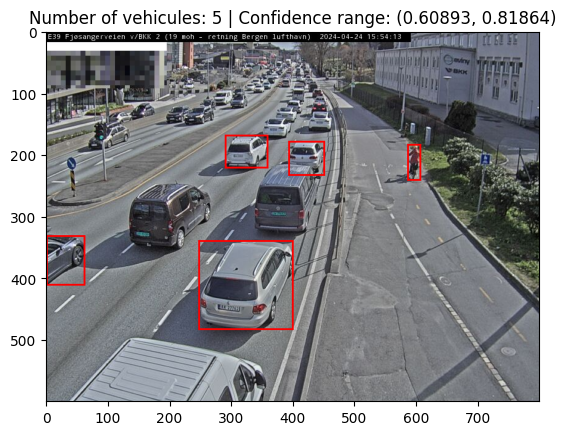

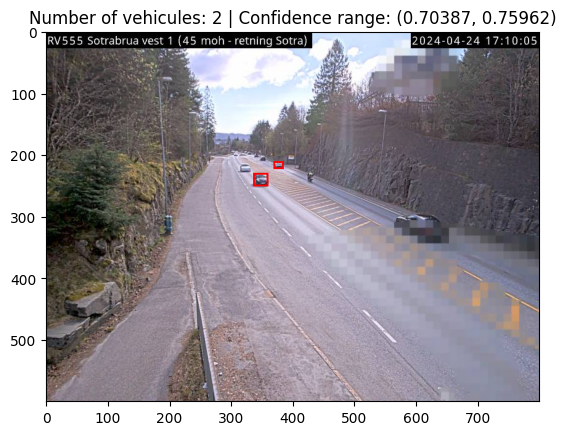

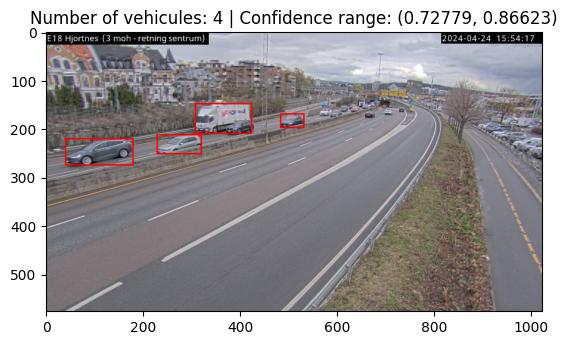

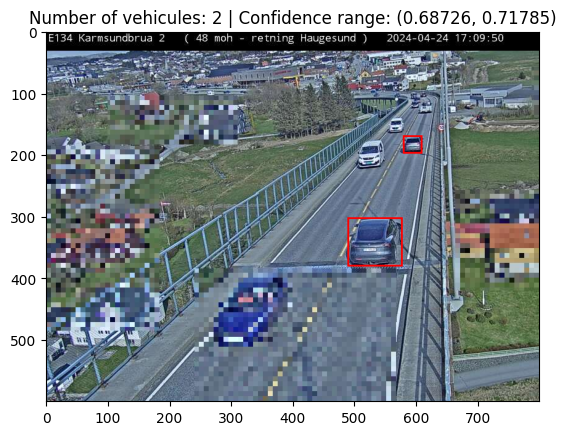

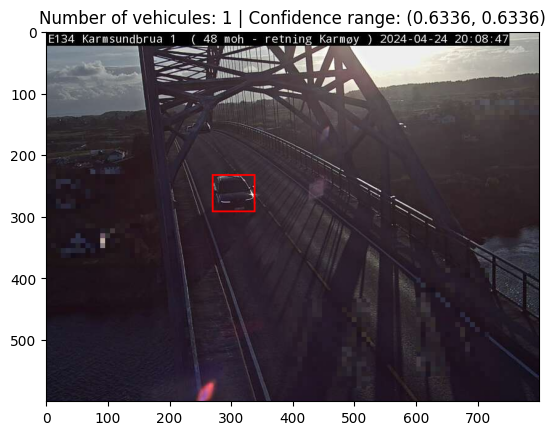

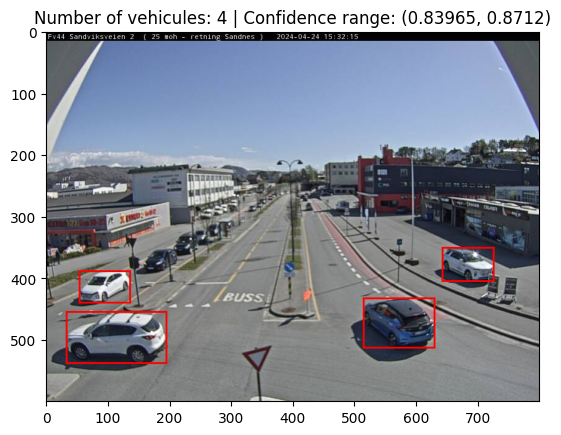

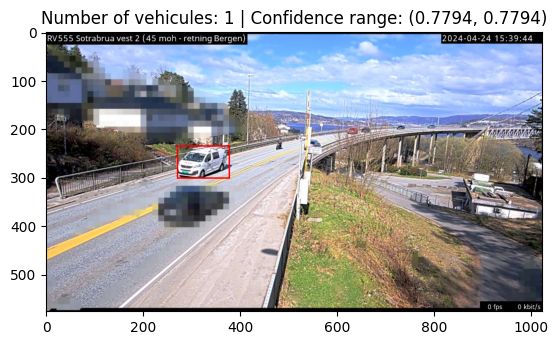

In [39]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import random

# randomly choose images
num_samples = 10
print(f"Randomly sampling {num_samples} images from validation dataset...")
images = random.sample(raw_dataset['validation']['image'], num_samples)
print(f"Got {len(images)} images!")

for i, image in enumerate(tqdm(images, f"Running inference on {len(images)} images...", leave=True)):
    draw = ImageDraw.Draw(image)

    results = model(image, verbose=False)[0].to_df()

    if results.empty:
        print(f"No objects detected in image {i}.")
    else:
        # Filter using the minimum confidence of the model (the threshold)
        results = results[results["confidence"] >= model.conf]

        boxes = results["box"].values
        conf = results["confidence"].values
        classes = results["class"].values
        index_list = [2,3,5,7]

        # Draw matches
        for box in boxes:
            xmin, ymin, xmax, ymax = box.values()
            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline = 'red', width=3)

    array_image = np.array(image)

    num_objects = len(boxes) if len(results) != 0 else 0
    confidence_range = (float(conf.min()), float(conf.max())) if len(results) != 0 else None

    # Create a new figure for each image and show it
    plt.figure()
    plt.title(f'Number of vehicules: {num_objects} | Confidence range: {confidence_range}')
    plt.imshow(array_image)